In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# from linearmodels.panel.data import PanelData
# from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
import pyblp

In [12]:
product_data=pd.read_csv("../../data/merged/len3_ndb_agg_blp_imputed_lags.csv",encoding="shift-jis",index_col=0)
product_data["market_ids"]=product_data["薬効分類"].astype(int).astype(str)+"-"+product_data["year"].astype(int).astype(str)
product_data["generic_share_q"].fillna(0,inplace=True)
product_data["generic_share_r"].fillna(0,inplace=True)
product_data.rename(columns={"薬価":"prices","r_share":"shares",
                    "elasped_0":"demand_instruments0",
                    "elasped_1":"demand_instruments1",
                    'elasped_2': 'demand_instruments2',
                    'elasped_3': 'demand_instruments3',
                    'elasped_4': 'demand_instruments4',
                    'elasped_5': 'demand_instruments5',
                    'elasped_6': 'demand_instruments6',
                    'elasped_7': 'demand_instruments7',
                    'elasped_8': 'demand_instruments8',
                    'elasped_9': 'demand_instruments9',
                    # "generic_per":"demand_instruments4",
                    "mean_price":"demand_instruments10",
                    # "otc_dom":"demand_instruments2",
                    "lag_mean_price":"demand_instruments11",
                    # "generic_share_q":"demand_instruments7",
                    "generic_share_r":"demand_instruments12"
                    },inplace=True)
product_data=product_data.loc[product_data["shares"]>0]
# data["shares"]=data["r_share"]
product_data.head()

,薬効分類,薬効分類名称,医薬品コード,医薬品名,薬価基準収載医薬品コード,prices,後発品区分,総計,year,in_hospital,...,id_441.0,id_449.0,id_625.0,id_629.0,id_799.0,q_share,shares,generic_share_q,demand_instruments12,market_ids
0,114.0,解熱鎮痛消炎剤,661140242.0,インテバン坐剤５０ ５０ｍｇ,1145700J3012,19.3,0.0,292190.95,2014.0,1,...,0.0,0.0,0.0,0.0,0.0,0.000085,0.000036,0.236031,0.053874,114-2014
1,114.0,解熱鎮痛消炎剤,661140216.0,インテバン坐剤２５ ２５ｍｇ,1145700J2016,19.3,0.0,128832.00,2014.0,1,...,0.0,0.0,0.0,0.0,0.0,0.000038,0.000016,0.236031,0.053874,114-2014
2,114.0,解熱鎮痛消炎剤,661140020.0,インドメタシン坐剤 ５０ｍｇ,1145700J3012,19.3,0.0,106328.00,2014.0,1,...,0.0,0.0,0.0,0.0,0.0,0.000031,0.000013,0.236031,0.053874,114-2014
3,114.0,解熱鎮痛消炎剤,661140242.0,インテバン坐剤５０ ５０ｍｇ,1145700J3012,19.3,0.0,658257.00,2014.0,0,...,0.0,0.0,0.0,0.0,0.0,0.000192,0.000081,0.236031,0.053874,114-2014
4,114.0,解熱鎮痛消炎剤,661140216.0,インテバン坐剤２５ ２５ｍｇ,1145700J2016,19.3,0.0,418727.50,2014.0,0,...,0.0,0.0,0.0,0.0,0.0,0.000122,0.000051,0.236031,0.053874,114-2014


In [13]:
logit_formulation = pyblp.Formulation('prices+oral+in_hospital+後発品区分', absorb='C(薬効分類)+C(year)')
logit_formulation

prices + oral + in_hospital + 後発品区分 + Absorb[C(薬効分類)] + Absorb[C(year)]

In [14]:
# product_data["shares"]-=1e-10
problem = pyblp.Problem(logit_formulation, product_data)
problem

Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     K1    MD    ED 
---  -----  ----  ----  ----
264  29653   4     16    2  

Formulations:
     Column Indices:          0      1         2         3  
--------------------------  ------  ----  -----------  -----
X1: Linear Characteristics  prices  oral  in_hospital  後発品区分


Dimensions:
 T     N     K1    MD    ED 
---  -----  ----  ----  ----
264  29653   4     16    2  

Formulations:
     Column Indices:          0      1         2         3  
--------------------------  ------  ----  -----------  -----
X1: Linear Characteristics  prices  oral  in_hospital  後発品区分

In [15]:
logit_results = problem.solve()
logit_results

Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix
Step      Value      Shares   Condition Number
----  -------------  -------  ----------------
 1    +4.726866E+02     0      +1.286178E+07  

Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 2    +9.533998E+01     0      +1.623746E+07      +2.916435E+06  

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital         後発品区分     
---------------  ---------------  ---------------  ---------------
 +2.839869E-04    +1.836016E+00    +4

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 2    +9.533998E+01     0      +1.623746E+07      +2.916435E+06  

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital         後発品区分     
---------------  ---------------  ---------------  ---------------
 +2.839869E-04    +1.836016E+00    +4.492137E-01    -1.466521E+00 
(+2.138963E-04)  (+6.374156E-02)  (+2.691966E-02)  (+1.045268E-01)

In [16]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Format the time as a string
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")

logit_results.to_pickle(f"./results/MNL_len3_{time_string}.pkl")

In [17]:
# how to load pickle
# import pickle
# with open("./results/logit_blp_len3.pkl", "rb") as f:
#     example = pickle.load(f)
# example

In [18]:
elasticities = logit_results.compute_elasticities()

Computing elasticities with respect to prices ...
Finished after 00:00:00.



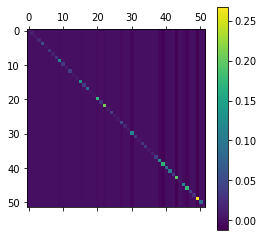

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
single_market = product_data['market_ids'] == '131-2014'
K=sum(single_market)
plt.colorbar(plt.matshow(elasticities[single_market][:,:K]))

In [20]:
elasticities[single_market][:,:K]

array([[ 1.30184570e-02, -6.74133569e-05, -4.04023650e-05, ...,
        -1.19658005e-02, -9.10821401e-04, -5.44195478e-06],
       [-1.65407844e-05,  1.29675844e-02, -4.04023650e-05, ...,
        -1.19658005e-02, -9.10821401e-04, -5.44195478e-06],
       [-1.65407844e-05, -6.74133569e-05,  7.65564207e-03, ...,
        -1.19658005e-02, -9.10821401e-04, -5.44195478e-06],
       ...,
       [-1.65407844e-05, -6.74133569e-05, -4.04023650e-05, ...,
         2.67818073e-01, -9.10821401e-04, -5.44195478e-06],
       [-1.65407844e-05, -6.74133569e-05, -4.04023650e-05, ...,
        -1.19658005e-02,  8.34616806e-02, -5.44195478e-06],
       [-1.65407844e-05, -6.74133569e-05, -4.04023650e-05, ...,
        -1.19658005e-02, -9.10821401e-04,  6.52625628e-03]])